# Project Goal:

Build a model to forecast the demand (passengers and cargo traffic) in airplane.) The data is classified in date/time and the passengers travellings and cargo shipment per month.

In [311]:
import pandas as pd
import numpy as np

%matplotlib inline

import os
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

In [4]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [78]:
tsdf=pd.read_pickle('./tsdata.pkl' )

In [50]:
tsdf.head()

,PAYLOAD,PASSENGERS,SEATS,FREIGHT,MAIL,EMPTY_SEATS
DATE,,,,,,
2010-01-01,2.022123e+10,46717947.0,66617337.0,1.582087e+09,80877028.0,19899390.0
2010-02-01,1.823153e+10,43498396.0,59442504.0,1.529047e+09,71246086.0,15944108.0
2010-03-01,2.146774e+10,55804909.0,70673162.0,1.764835e+09,81715979.0,14868253.0
2010-04-01,2.102538e+10,53768509.0,68726880.0,1.746444e+09,77466932.0,14958371.0
2010-05-01,2.134554e+10,55184999.0,70321656.0,1.714055e+09,72221966.0,15136657.0


In [79]:
tsdf=tsdf.reset_index()

In [80]:
tsdf.head()

,DATE,PAYLOAD,PASSENGERS,SEATS,FREIGHT,MAIL,EMPTY_SEATS
0,2010-01-01,2.022123e+10,46717947.0,66617337.0,1.582087e+09,80877028.0,19899390.0
1,2010-02-01,1.823153e+10,43498396.0,59442504.0,1.529047e+09,71246086.0,15944108.0
2,2010-03-01,2.146774e+10,55804909.0,70673162.0,1.764835e+09,81715979.0,14868253.0
3,2010-04-01,2.102538e+10,53768509.0,68726880.0,1.746444e+09,77466932.0,14958371.0
4,2010-05-01,2.134554e+10,55184999.0,70321656.0,1.714055e+09,72221966.0,15136657.0


In [81]:
tsdf['QUARTER']=tsdf.DATE.dt.quarter
tsdf['MONTH']=tsdf.DATE.dt.month

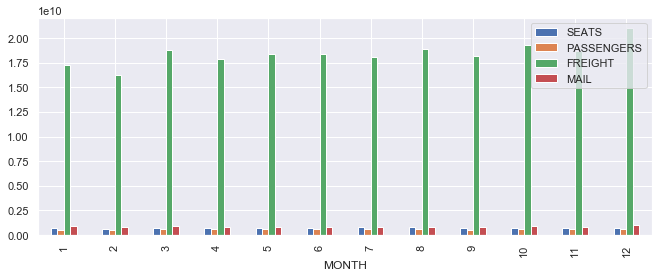

In [89]:
tsdf.groupby('MONTH').sum()[['SEATS','PASSENGERS','FREIGHT','MAIL']
                             ].plot(kind='bar');

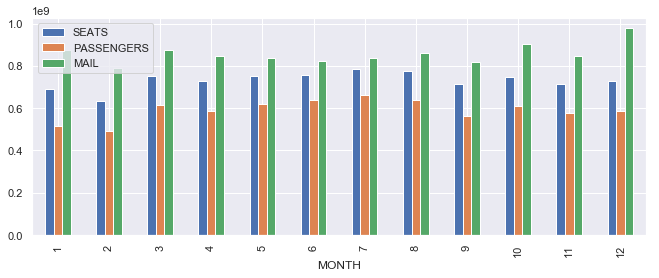

In [90]:
tsdf.groupby('MONTH').sum()[['SEATS','PASSENGERS','MAIL']
                             ].plot(kind='bar');

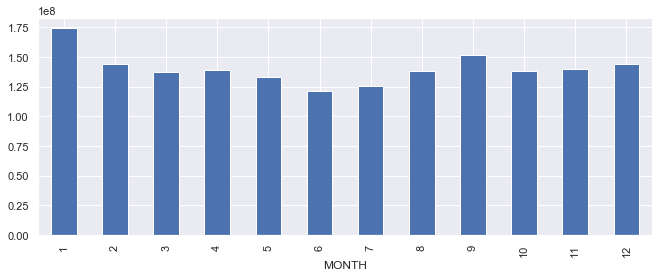

In [87]:
tsdf.groupby('MONTH').sum()['EMPTY_SEATS'].plot(kind='bar');

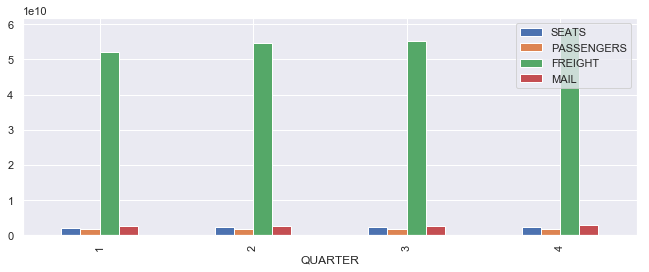

In [91]:
tsdf.groupby('QUARTER').sum()[['SEATS','PASSENGERS','FREIGHT','MAIL']
                             ].plot(kind='bar');

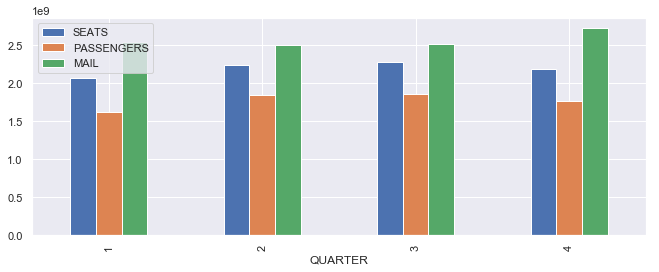

In [92]:
tsdf.groupby('QUARTER').sum()[['SEATS','PASSENGERS','MAIL']
                             ].plot(kind='bar');

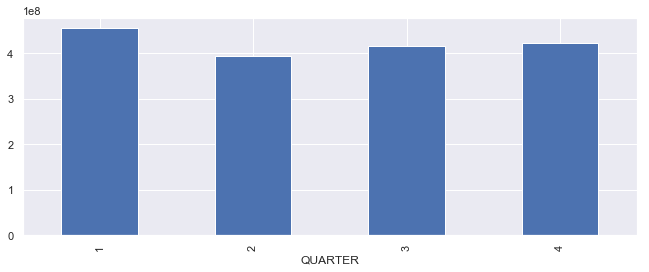

In [93]:
tsdf.groupby('QUARTER').sum()['EMPTY_SEATS'].plot(kind='bar');

In [94]:
tsdf=tsdf.set_index('DATE')

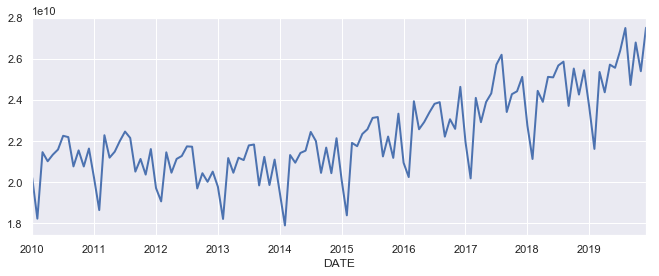

In [145]:
tsdf['PAYLOAD'].plot(linewidth=2);

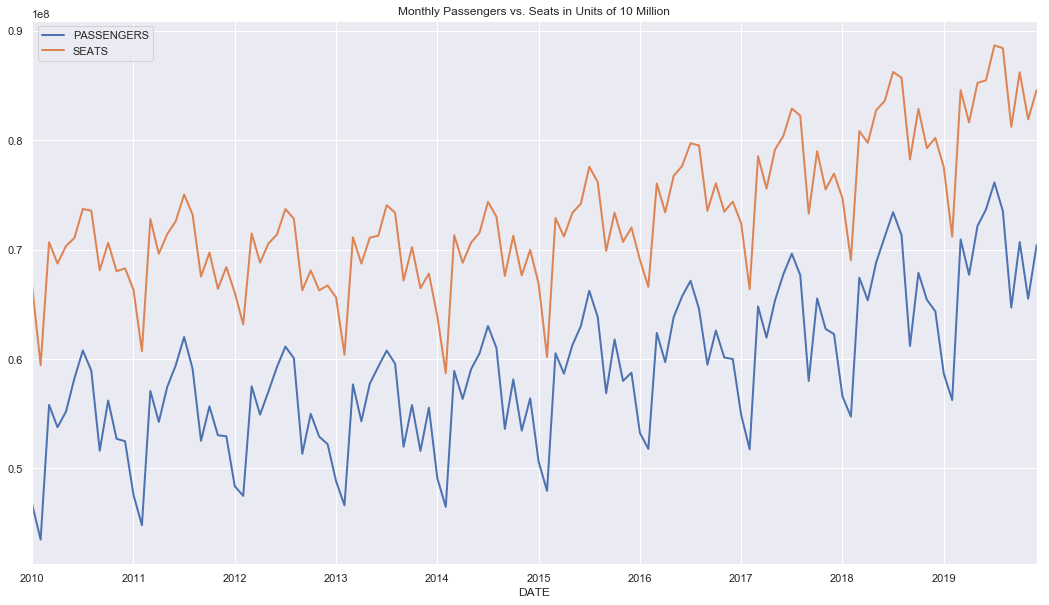

In [140]:
fig, ax = plt.subplots(1, figsize=(18, 10))
tsdf['PASSENGERS'].plot(linewidth=2);
tsdf['SEATS'].plot(linewidth=2)
plt.legend()
plt.title("Monthly Passengers vs. Seats in Units of 10 Million");

Text(0.5, 1.0, 'Monthly Pounds of Freight in Units of 1 Billion')

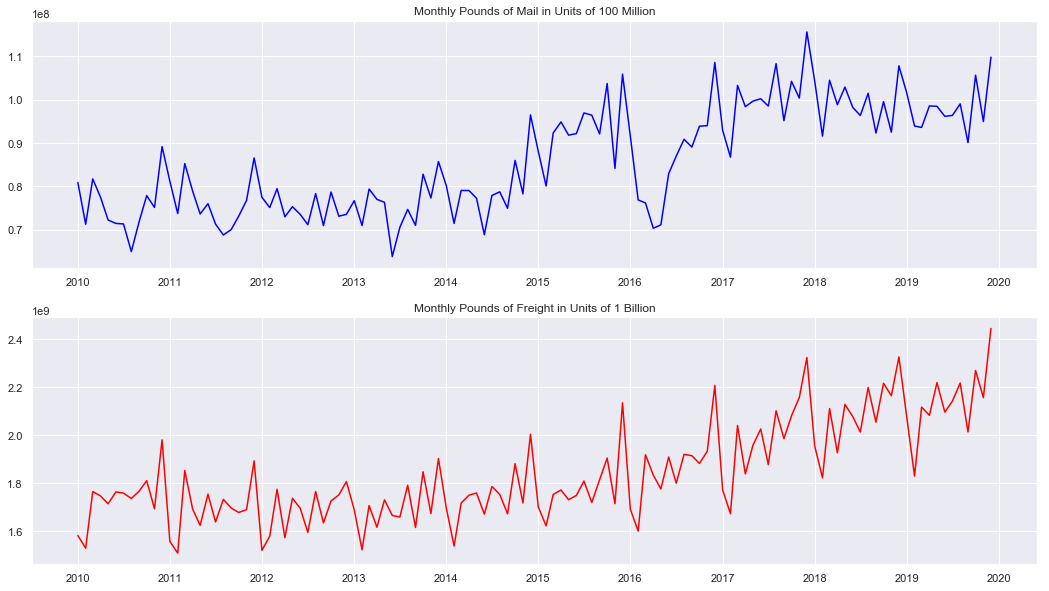

In [142]:
fig, ax = plt.subplots(2, figsize=(18, 10))
ax[0].plot(tsdf.index, tsdf['MAIL'], color = "blue")
ax[1].plot(tsdf.index, tsdf['FREIGHT'], color= "red")
ax[0].set_title("Monthly Pounds of Mail in Units of 100 Million")
ax[1].set_title("Monthly Pounds of Freight in Units of 1 Billion")

In [101]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Monthly Passengers")

Text(0.5, 1.0, 'Percentage of Seats Unfilled')

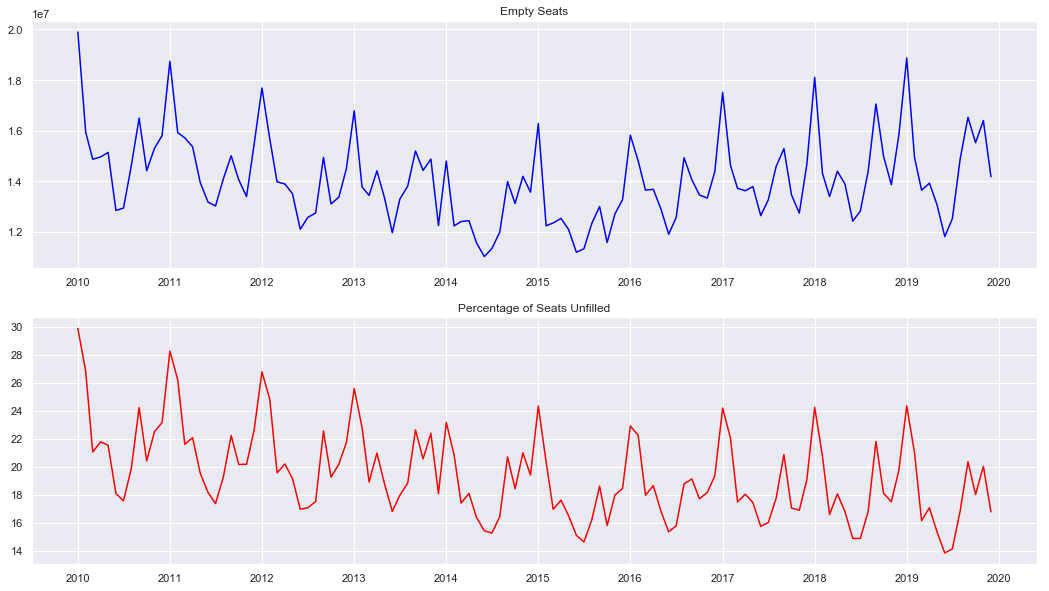

In [106]:
fig, ax = plt.subplots(2, figsize=(18, 10))
ax[0].plot(tsdf.index, (tsdf.SEATS-tsdf.PASSENGERS), color = "blue")
ax[1].plot(tsdf.index, (((tsdf.SEATS-tsdf.PASSENGERS)/tsdf.SEATS)*100), color= "red")
ax[0].set_title("Empty Seats")
ax[1].set_title("Percentage of Seats Unfilled")

## Stationarity Check

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean, variance of the data.

When a time series is stationary, it can be easier to model.

From our data, we can see that the mean and variance do change over time. We can see both trend and seasonal components.

In [179]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series,label='Original')
    ax.set_title("Monthly {}".format(name))

def fit_moving_average_trend(series, window=12):
    return series.rolling(window, center=True).mean()

def fit_moving_std_trend(series, window=12):
    return series.rolling(window, center=True).std()

def plot_moving_average_trend(ax, name, series, window=12):
    moving_average_trend = fit_moving_average_trend(series, window)   
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend,label='Rolling Mean')
    
def plot_moving_std_trend(ax, name, series, window=12):
    moving_std_trend = fit_moving_std_trend(series, window)   
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_std_trend,label='Rolling Std')

# moving_std_trend = fit_moving_std_trend(series, window)
# ax.plot(series.index, moving_std_trend,label='Rolling Std')
    

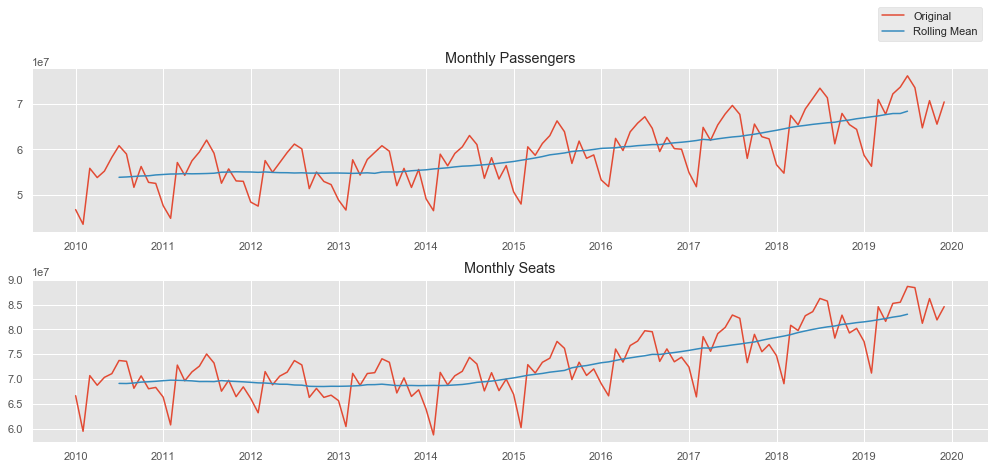

In [283]:
#Moving average 
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', tsdf['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', tsdf['SEATS'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,2.7));

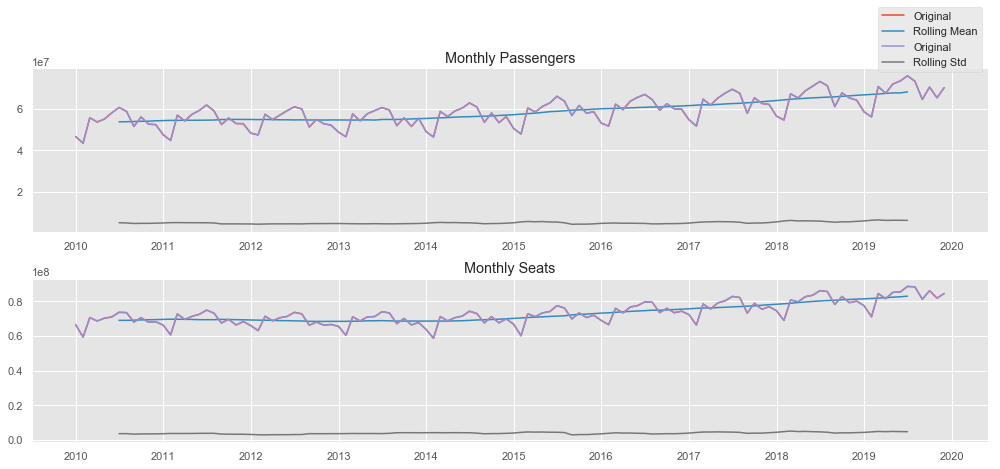

In [284]:
#with standard deviation
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', tsdf['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', tsdf['SEATS'])

plot_moving_std_trend(axs[0], 'Passengers', tsdf['PASSENGERS'])
plot_moving_std_trend(axs[1], 'Seats', tsdf['SEATS'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,2.7));

In [216]:
#testing for stationarity
#perform Dickey-Fuller test:

print('Results of Dickey-Fuller Test: ')
dftest=adfuller(tsdf['PASSENGERS'],autolag='AIC')

dfoutput=pd.Series(dftest[0:4], index= ['Test Statsitics', 'p-value',
                                       '#Lags Used','#Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
    
print(dfoutput)

# If the test statistic is less extreme than the critical value, 
# do not reject the null hypothesis.

#In this situation, our test statistics is greater than critical value,
#we reject the null hypothesis and we conclude that the data is non-stationary


Results of Dickey-Fuller Test: 
Test Statsitics           2.684559
p-value                   0.999086
#Lags Used               13.000000
#Observations Used      106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


In [264]:
#Let's write this into a function

#testing for stationarity
def test_stationarity(timeseries):

    #perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['PASSENGERS'], autolag='AIC')

    dfoutput=pd.Series(dftest[0:4], index= ['Test Statsitics', 'p-value',
                                           '#Lags Used','#Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key]=value

    print(dfoutput)

In [186]:
test = adfuller(tsdf['PASSENGERS'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

#with differencing
test = adfuller(tsdf['PASSENGERS'].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

#double differencing
test = adfuller(tsdf['PASSENGERS'].diff()[1:].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 1.00
ADF p-value for python series: 0.45
ADF p-value for python series: 0.00


In [187]:
#testing for stationarity
test = adfuller(tsdf['SEATS'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

#with differencing
test = adfuller(tsdf['SEATS'].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

#double differencing
test = adfuller(tsdf['SEATS'].diff()[1:].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 1.00
ADF p-value for python series: 0.51
ADF p-value for python series: 0.00


## Feature Engineering

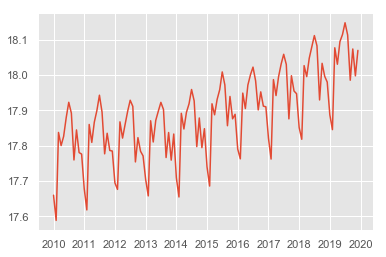

In [195]:
#log transformation
tsdf_logscale=np.log(tsdf)
plt.plot(tsdf_logscale['PASSENGERS']);

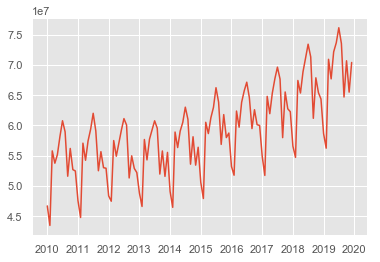

In [196]:
#comparison: you can see that the trend still remains the same
#vs the value of y has been changed
plt.plot(tsdf.PASSENGERS)

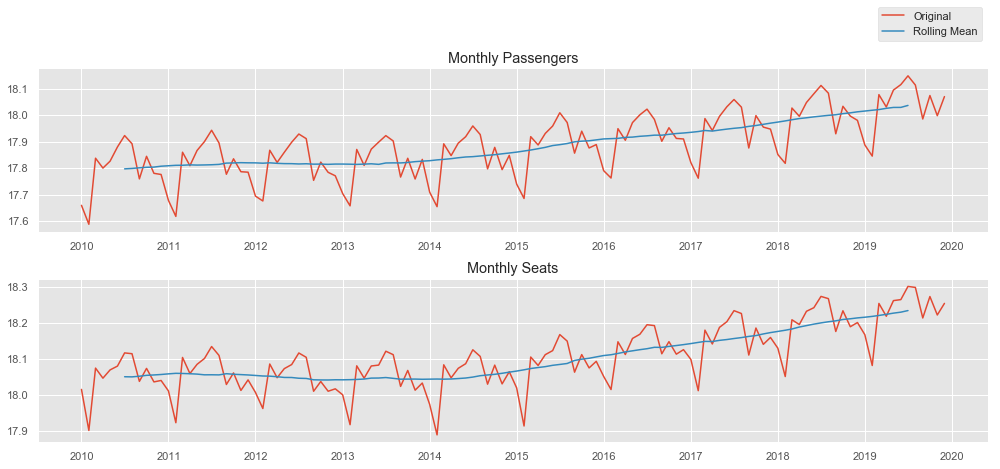

In [286]:
#with standard deviation
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', tsdf_logscale['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', tsdf_logscale['SEATS'])

# plot_moving_std_trend(axs[0], 'Passengers', tsdf_logscale['PASSENGERS'])
# plot_moving_std_trend(axs[1], 'Seats', tsdf_logscale['SEATS'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,2.7));

In [269]:
tsdf_logscaleMinusMA= (tsdf_logscale-
                        tsdf_logscale.rolling(window=12).mean())

In [270]:
tsdf_logscaleMinusMA.head()

,PAYLOAD,PASSENGERS,SEATS,FREIGHT,MAIL,EMPTY_SEATS,QUARTER,MONTH
DATE,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
#remove nan values
tsdf_logscaleMinusMA.dropna(inplace=True)
tsdf_logscaleMinusMA.head()

,PAYLOAD,PASSENGERS,SEATS,FREIGHT,MAIL,EMPTY_SEATS,QUARTER,MONTH
DATE,,,,,,,,
2010-12-01,0.027134,-0.021155,-0.010355,0.132848,0.170388,0.040481,0.591781,0.819305
2011-01-01,-0.041826,-0.120601,-0.039103,-0.106123,0.075928,0.215899,-0.794513,-1.665601
2011-02-01,-0.123621,-0.183303,-0.129070,-0.136500,-0.022933,0.053119,-0.794513,-0.972454
2011-03-01,0.051751,0.056841,0.049637,0.064598,0.119053,0.035377,-0.794513,-0.566989
2011-04-01,0.000782,0.005321,0.003936,-0.022869,0.040370,0.010524,-0.101366,-0.279307


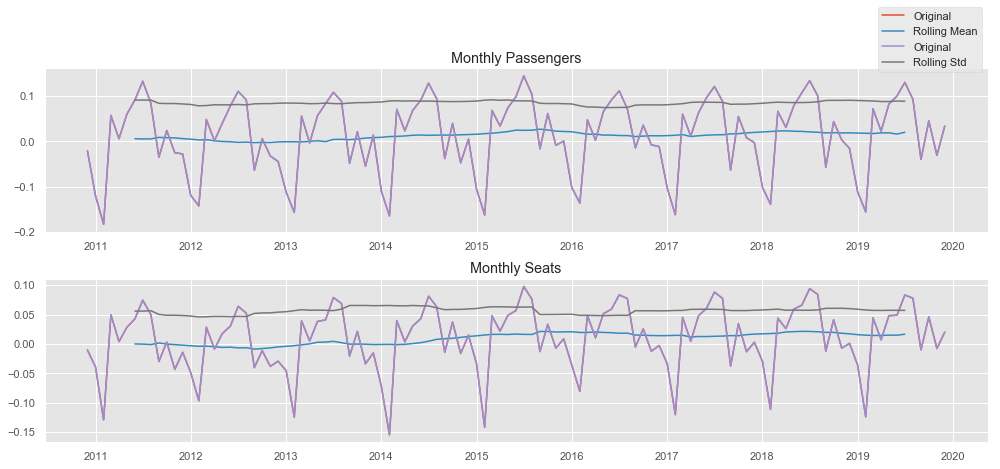

In [288]:
#Moving average 
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', tsdf_logscaleMinusMA['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', tsdf_logscaleMinusMA['SEATS'])

plot_moving_std_trend(axs[0], 'Passengers', tsdf_logscaleMinusMA['PASSENGERS'])
plot_moving_std_trend(axs[1], 'Seats', tsdf_logscaleMinusMA['SEATS'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,2.7));

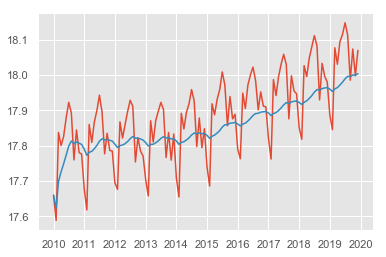

In [275]:
#exponential
exponentialWeightedAverage=tsdf_logscale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(tsdf_logscale['PASSENGERS'])
plt.plot(exponentialWeightedAverage['PASSENGERS'])


In [277]:
tsdf_logscaleMinusExponentialWeightedAverage=tsdf_logscale-exponentialWeightedAverage

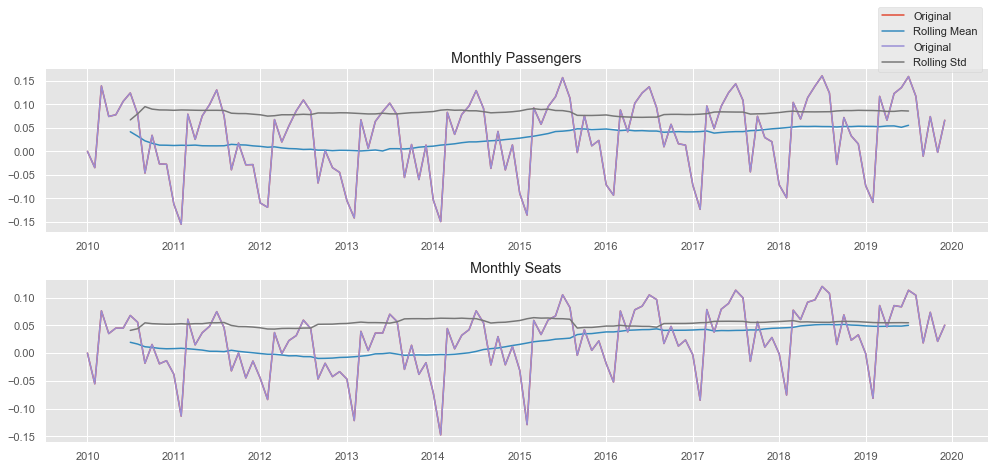

In [289]:
#Moving average 
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', tsdf_logscaleMinusExponentialWeightedAverage['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', tsdf_logscaleMinusExponentialWeightedAverage['SEATS'])

plot_moving_std_trend(axs[0], 'Passengers', tsdf_logscaleMinusExponentialWeightedAverage['PASSENGERS'])
plot_moving_std_trend(axs[1], 'Seats', tsdf_logscaleMinusExponentialWeightedAverage['SEATS'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,2.7));

In [274]:
#tsdf_logscale
test_stationarity(tsdf_logscale)

Results of Dickey-Fuller Test: 
Test Statsitics           2.317568
p-value                   0.998966
#Lags Used               13.000000
#Observations Used      106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


In [379]:
print('Results of Dickey-Fuller Test: ')
dftest=adfuller(tsdf_logscale['PASSENGERS'].diff()[1:],autolag='AIC')

dfoutput=pd.Series(dftest[0:4], index= ['Test Statsitics', 'p-value',
                                       '#Lags Used','#Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
    
print(dfoutput)

# If the test statistic is less extreme than the critical value, 
# do not reject the null hypothesis.

#In this situation, our test statistics is greater than critical value,
#we reject the null hypothesis and we conclude that the data is non-stationary

Results of Dickey-Fuller Test: 
Test Statsitics          -1.935072
p-value                   0.315746
#Lags Used               13.000000
#Observations Used      105.000000
Critical Value (1%)      -3.494220
Critical Value (5%)      -2.889485
Critical Value (10%)     -2.581676
dtype: float64


In [380]:
print('Results of Dickey-Fuller Test: ')
dftest=adfuller(tsdf_logscale['PASSENGERS'].diff()[1:].diff()[1:],autolag='AIC')

dfoutput=pd.Series(dftest[0:4], index= ['Test Statsitics', 'p-value',
                                       '#Lags Used','#Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
    
print(dfoutput)

# If the test statistic is less extreme than the critical value, 
# do not reject the null hypothesis.

#In this situation, our test statistics is greater than critical value,
#we reject the null hypothesis and we conclude that the data is non-stationary

Results of Dickey-Fuller Test: 
Test Statsitics        -1.097988e+01
p-value                 7.505449e-20
#Lags Used              1.300000e+01
#Observations Used      1.040000e+02
Critical Value (1%)    -3.494850e+00
Critical Value (5%)    -2.889758e+00
Critical Value (10%)   -2.581822e+00
dtype: float64


In [272]:
test_stationarity(tsdf_logscaleMinusMA)

Results of Dickey-Fuller Test: 
Test Statsitics         -1.078676
p-value                  0.723500
#Lags Used              13.000000
#Observations Used      95.000000
Critical Value (1%)     -3.501137
Critical Value (5%)     -2.892480
Critical Value (10%)    -2.583275
dtype: float64


In [278]:
test_stationarity(tsdf_logscaleMinusExponentialWeightedAverage)

Results of Dickey-Fuller Test: 
Test Statsitics          -0.271330
p-value                   0.929468
#Lags Used               13.000000
#Observations Used      106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


In [273]:
test_stationarity(tsdf)

Results of Dickey-Fuller Test: 
Test Statsitics           2.684559
p-value                   0.999086
#Lags Used               13.000000
#Observations Used      106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


## Seasonal Decomposition

In [300]:
passengers_decomposition = sm.tsa.seasonal_decompose(tsdf['PASSENGERS'])
seats_decomposition = sm.tsa.seasonal_decompose(tsdf['SEATS'])

In [292]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

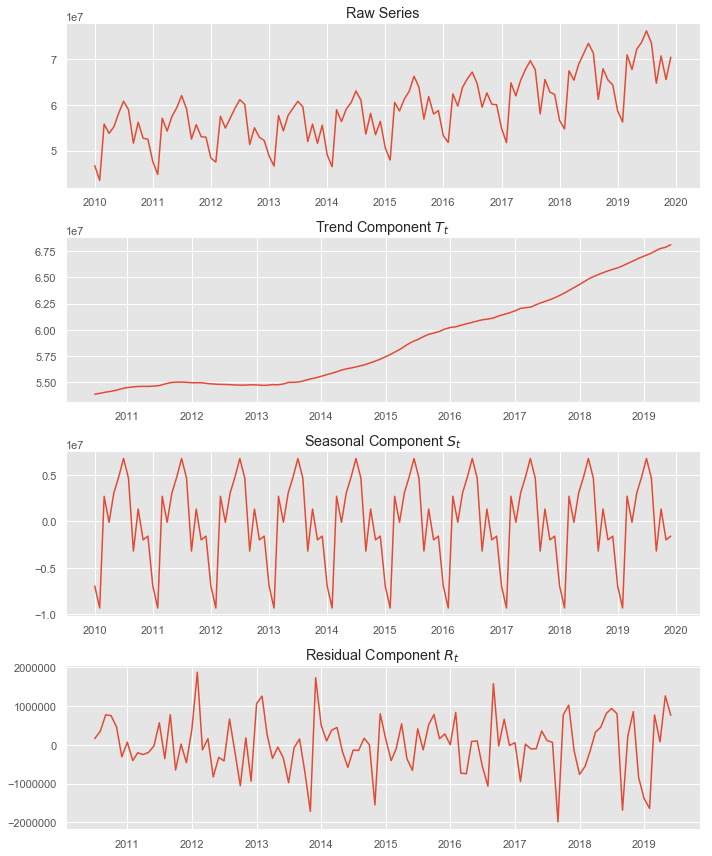

In [293]:
fig, axs = plt.subplots(4, figsize=(10, 12))
plot_seasonal_decomposition(axs, tsdf['PASSENGERS'], passengers_decomposition)
plt.tight_layout()

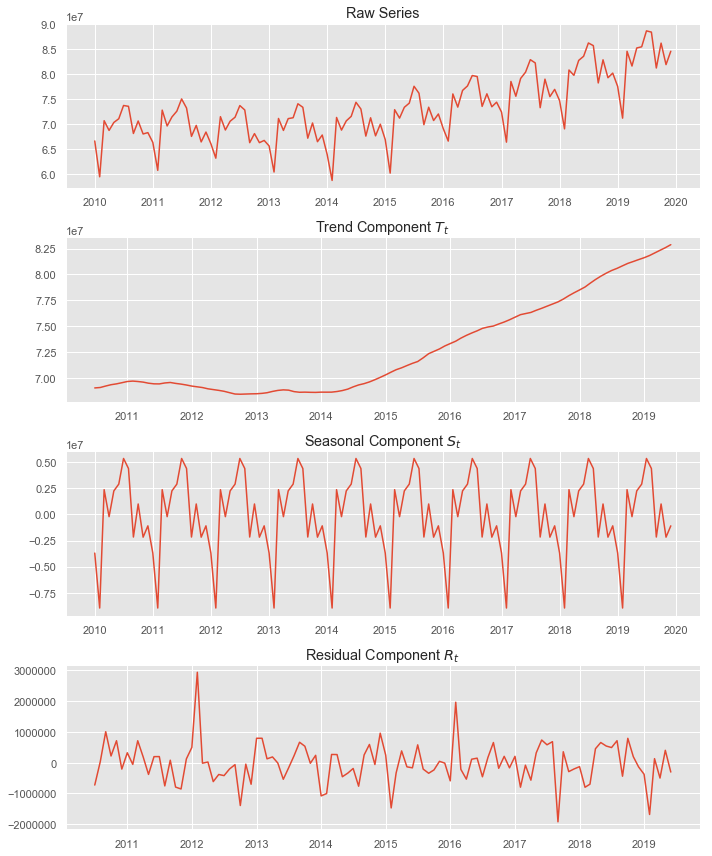

In [305]:
fig, axs = plt.subplots(4, figsize=(10, 12))
plot_seasonal_decomposition(axs, tsdf['SEATS'], seats_decomposition)
plt.tight_layout()

## Differencing

In [359]:
#work for arima order
#find the standard deviation of the differencing
#then compute differencing on the differencing
#and compare both to the standard deviation of the raw time series data
#usually a lower one is better


print(tsdf.PASSENGERS.std())
print(tsdf_logscale.PASSENGERS.std())
print(tsdf_logscale.diff()[1:].PASSENGERS.std())
print(tsdf_logscale.diff()[1:].diff()[1:].PASSENGERS.std())

#we can conclude that we use 1 differencing.

6921719.773389815
0.11771794277988995
0.09112961352246336
0.1485066390492464


In [307]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

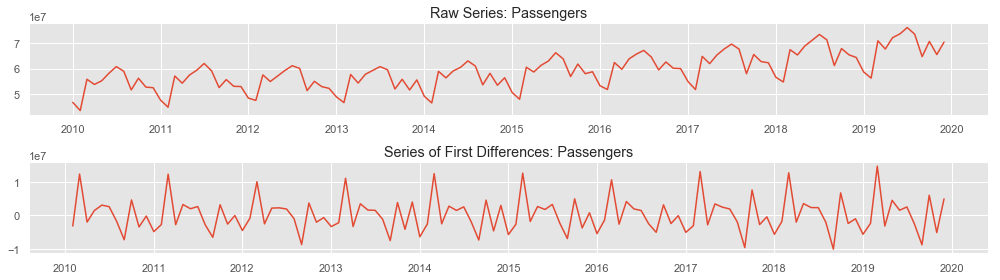

In [308]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, tsdf['PASSENGERS'], 'Passengers')
fig.tight_layout()

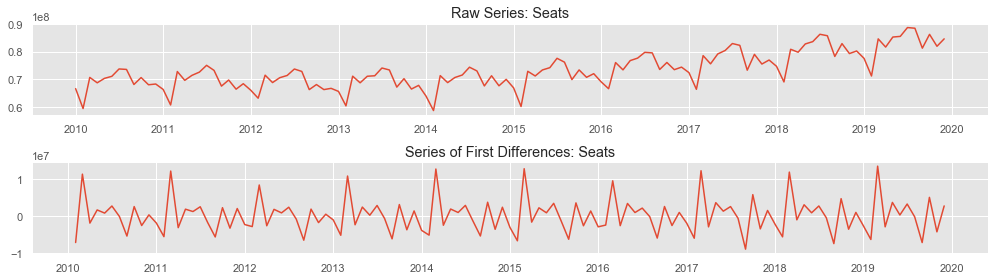

In [309]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, tsdf['SEATS'], 'Seats')
fig.tight_layout()

## ACF & PACF 

In [369]:
#nlags: it is the number of observations  you are looking back on
#since we have monthly data,the first value in acf is always 1
#the second value is the current month and the previous month
#the third value is the current month and two months ago etc..

lag_acf=pacf(tsdf_logscale['PASSENGERS'].diff()[1:], nlags=20)
lag_pacf=pacf(tsdf_logscale['PASSENGERS'].diff()[1:], nlags=20, method='ols')

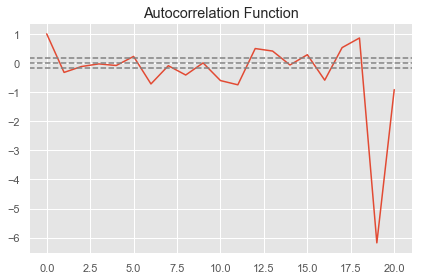

In [370]:
#plot ACF:

# plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(tsdf_logscale['PASSENGERS'].diff()[1:])),
                           linestyle='--',color='grey') 
plt.axhline(y=1.96/np.sqrt(len(tsdf_logscale['PASSENGERS'].diff()[1:])),
                           linestyle='--',color='grey') 
plt.title('Autocorrelation Function')
plt.tight_layout()

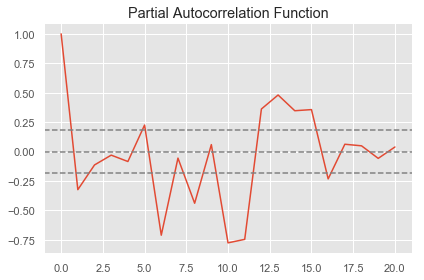

In [371]:
# plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(tsdf_logscale['PASSENGERS'].diff()[1:])),
                           linestyle='--',color='grey') 
plt.axhline(y=1.96/np.sqrt(len(tsdf_logscale['PASSENGERS'].diff()[1:])),
                           linestyle='--',color='grey') 
plt.title('Partial Autocorrelation Function')

plt.tight_layout()



#we see conclude that Q=2 

In [312]:
# looking for autocorrelation

def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

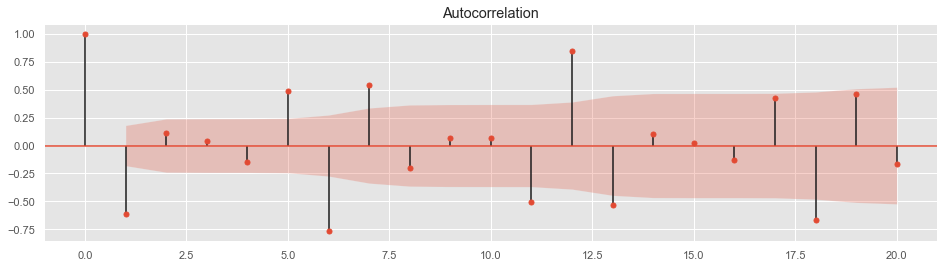

In [313]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(tsdf['PASSENGERS'].diff()[1:].diff()[1:], lags=20, ax=ax)

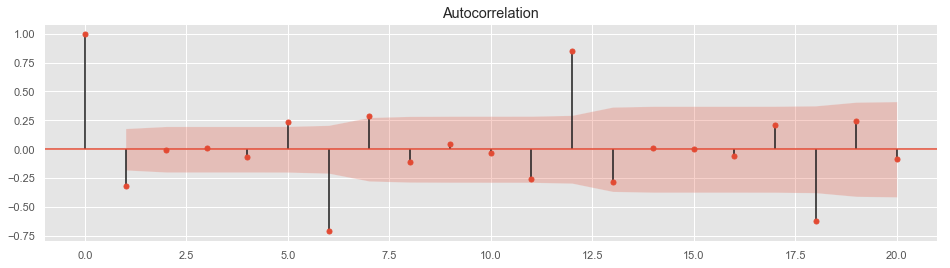

In [388]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(tsdf_logscale['PASSENGERS'].diff()[1:], lags=20, ax=ax)

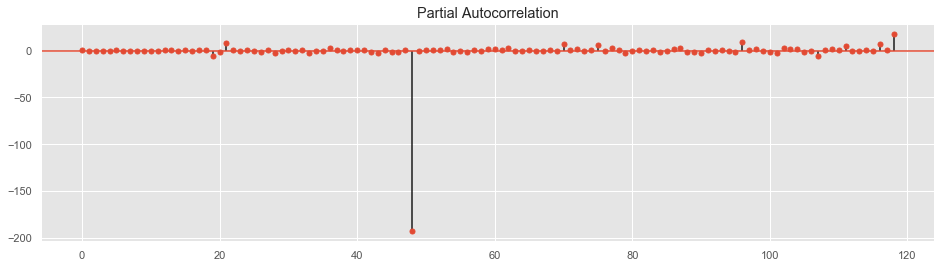

In [387]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(tsdf['PASSENGERS'].diff()[1:], lags=119, ax=ax)



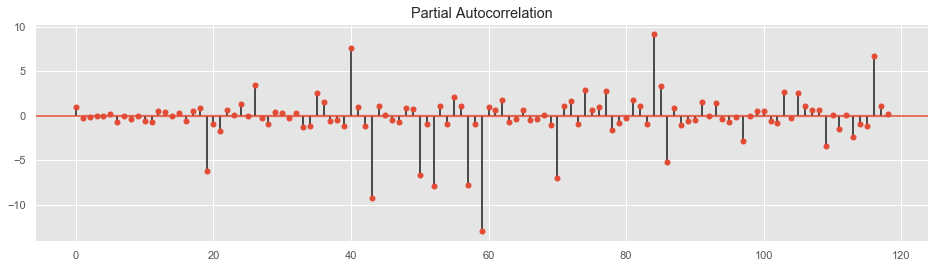

In [386]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(tsdf_logscale['PASSENGERS'].diff()[1:], lags=119, ax=ax)

## Model Building

Summary Interpretation:
1. We want to look at the AIC, BIC, or HQIC, the lower the value, the better the model, even if the value is negative
2. Then we look at the p-values. 

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


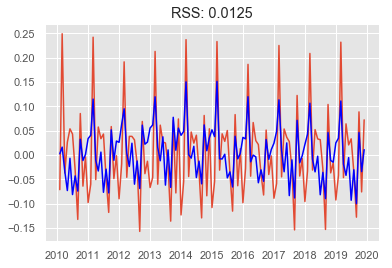

In [408]:
#ARIMA MODEL

model1=ARIMA(tsdf_logscale['PASSENGERS'],order=(2,1,2))
result_AR=model1.fit(disp=-1)
plt.plot(tsdf_logscale['PASSENGERS'].diff())
plt.plot(result_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum(result_AR.fittedvalues-
                          tsdf_logscale['PASSENGERS'].diff()[1:])**2 )



print('Plotting AR model')

In [444]:
#SARIMA MODEL 
model = SARIMAX((tsdf_logscale['PASSENGERS']), 
                order=(2,1,1), 
                seasonal_order=(2,1,2,12),
                freq=tsdf_logscale['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model.summary()

#if a variable has S in its name, that refers to the parameter in the seasonal order
#ma.S.L12 means moving average in the seasonal order
#ma.L1 refers to moving average in the order 1

Optimization terminated successfully.
         Current function value: -2.432798
         Iterations: 12
         Function evaluations: 1293


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  120
Model:             SARIMAX(2, 1, 1)x(2, 1, 2, 12)   Log Likelihood                 291.936
Date:                            Thu, 26 Mar 2020   AIC                           -567.871
Time:                                    22:26:09   BIC                           -546.489
Sample:                                01-01-2010   HQIC                          -559.203
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3353      0.216     -1.556      0.120      -0.758       0.087
ar.L2         -0.1676      0.170     -0.988      0.323      -0.500       0.165
ma.L1         -0.4987      0.231     -2.158      0.031      -0.952      -0.046
ar.S.L12       0.9174      0.464      1.978      0.048       0.009       1.826
ar.S.L24      -0.5532      0.195     -2.834      0.005      -0.936      -0.171
ma.S.L12      -1.4601      0.646     -2.259      0.024      -2.727      -0.193
ma.S.L24       0.7174      0.590      1.216      0.224      -0.439       1.874
sigma2         0.0002   4.88e-05      4.400      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.68   Jarque-Bera (JB):                14.19
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.47
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [448]:
#SARIMA MODEL ---> BEST MODEL
model2 = SARIMAX((tsdf_logscale['PASSENGERS']), 
                order=(2,2,2), 
                seasonal_order=(1,1,1,12),
                freq=tsdf_logscale['PASSENGERS'].index.inferred_freq,
                trend=[0,1,1,3]).fit(method = 'powell')
model2.summary()

#trend: 0*a + 1*bt + 1*ct^2 + 3*dt^3

Optimization terminated successfully.
         Current function value: -2.244731
         Iterations: 9
         Function evaluations: 1165


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  120
Model:             SARIMAX(2, 2, 2)x(1, 1, 1, 12)   Log Likelihood                 269.368
Date:                            Thu, 26 Mar 2020   AIC                           -518.736
Time:                                    22:31:55   BIC                           -492.101
Sample:                                01-01-2010   HQIC                          -507.940
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002   5.12e-05      3.789      0.000    9.36e-05       0.000
trend.2    -5.729e-06   1.42e-06     -4.043      0.000   -8.51e-06   -2.95e-06
trend.3      3.83e-08   9.08e-09      4.218      0.000    2.05e-08    5.61e-08
ar.L1         -0.6752    8.2e-09  -8.23e+07      0.000      -0.675      -0.675
ar.L2         -0.4319   3.35e-09  -1.29e+08      0.000      -0.432      -0.432
ma.L1         -0.8429   2.44e-08  -3.46e+07      0.000      -0.843      -0.843
ma.L2          0.1335   1.75e-08   7.61e+06      0.000       0.133       0.133
ar.S.L12       0.2381   5.24e-09   4.54e+07      0.000       0.238       0.238
ma.S.L12      -0.9984   1.11e-08  -8.98e+07      0.000      -0.998      -0.998
sigma2         0.0003   3.88e-05      7.385      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.15   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.23   Prob(JB):                         0.04
Heteroskedasticity (H):               0.87   Skew:                             0.55
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.41e+24. Standard errors may be unstable.
"""

In [423]:
#2ndBEST MODEL
#usually we can use 'ct' if we see an upward trend
model3 = SARIMAX(tsdf_logscale['PASSENGERS'], 
                 order=(0,1,1), seasonal_order=(1,1,1,12), 
                 trend='ct').fit(disp = -1)

model3.summary()

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 266.580
Date:                            Thu, 26 Mar 2020   AIC                           -521.160
Time:                                    22:19:08   BIC                           -505.123
Sample:                                01-01-2010   HQIC                          -514.659
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.773      0.006       0.000       0.002
drift       -9.63e-06   4.68e-06     -2.057      0.040   -1.88e-05   -4.55e-07
ma.L1         -0.9801      0.052    -18.742      0.000      -1.083      -0.878
ar.S.L12      -0.2096      0.256     -0.818      0.413      -0.711       0.292
ma.S.L12      -0.2376      0.227     -1.046      0.295      -0.683       0.207
sigma2         0.0003   4.24e-05      7.480      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      155.55   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               0.49   Skew:                             0.15
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [511]:
#P=1 current month is associated with last year same month
#Q: Moving average 
model4 = SARIMAX(tsdf_logscale['PASSENGERS'], 
                 order=(0,1,1), seasonal_order=(0,1,1,12), 
                 trend='ct').fit(disp = -1)

model4.summary()

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 270.680
Date:                            Thu, 26 Mar 2020   AIC                           -531.361
Time:                                    23:31:01   BIC                           -517.997
Sample:                                01-01-2010   HQIC                          -525.943
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      4.262      0.000       0.000       0.001
drift      -7.177e-06   3.09e-06     -2.325      0.020   -1.32e-05   -1.13e-06
ma.L1         -0.9801      0.049    -19.978      0.000      -1.076      -0.884
ma.S.L12      -0.4131      0.124     -3.333      0.001      -0.656      -0.170
sigma2         0.0003   4.14e-05      7.655      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      137.89   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.49   Skew:                             0.11
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [522]:
#BEST /FINAL MODEL
model5 = SARIMAX(tsdf_logscale['PASSENGERS'], 
                 order=(0,1,1), seasonal_order=(1,0,1,12), 
                 trend=[0,0,0,0]).fit(method = 'powell')

model5.summary()

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.474147
         Iterations: 7
         Function evaluations: 408


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 296.898
Date:                            Thu, 26 Mar 2020   AIC                           -585.795
Time:                                    23:35:08   BIC                           -574.679
Sample:                                01-01-2010   HQIC                          -581.281
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6808      0.075     -9.063      0.000      -0.828      -0.534
ar.S.L12       0.9993      0.001   1198.951      0.000       0.998       1.001
ma.S.L12      -0.7898      0.103     -7.632      0.000      -0.993      -0.587
sigma2         0.0003   3.26e-05      7.874      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       50.57   Jarque-Bera (JB):                13.28
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.62
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting and Predicting

In [572]:
df_train = tsdf.iloc[:112]
print(df_train.tail())
print(df_train.shape)
df_test = tsdf.iloc[112:]
print(df_test.head())
print(df_test.shape)

                 PAYLOAD  PASSENGERS       SEATS       FREIGHT         MAIL  \
DATE                                                                          
2018-12-01  2.545436e+10  64363721.0  80206321.0  2.325079e+09  107807704.0   
2019-01-01  2.365740e+10  58667594.0  77540913.0  2.075799e+09  101571742.0   
2019-02-01  2.162594e+10  56250607.0  71186822.0  1.829085e+09   93918241.0   
2019-03-01  2.536901e+10  70925783.0  84571028.0  2.116534e+09   93590305.0   
2019-04-01  2.437995e+10  67696442.0  81618854.0  2.081885e+09   98549490.0   

            EMPTY_SEATS  QUARTER  MONTH  
DATE                                     
2018-12-01   15842600.0        4     12  
2019-01-01   18873319.0        1      1  
2019-02-01   14936215.0        1      2  
2019-03-01   13645245.0        1      3  
2019-04-01   13922412.0        2      4  
(112, 8)
                 PAYLOAD  PASSENGERS       SEATS       FREIGHT        MAIL  \
DATE                                                             

In [573]:
best_model = SARIMAX((np.log(df_train['PASSENGERS'])), 
                order=(0,1,1), 
                seasonal_order=(1,0,1,12),
                freq=df_train['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0])
result=best_model.fit(method = 'powell')

result.summary()

Optimization terminated successfully.
         Current function value: -2.481985
         Iterations: 7
         Function evaluations: 402


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  112
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 277.982
Date:                            Fri, 27 Mar 2020   AIC                           -547.965
Time:                                    00:00:28   BIC                           -537.127
Sample:                                01-01-2010   HQIC                          -543.568
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6751      0.074     -9.129      0.000      -0.820      -0.530
ar.S.L12       0.9985      0.001    829.952      0.000       0.996       1.001
ma.S.L12      -0.6985      0.098     -7.148      0.000      -0.890      -0.507
sigma2         0.0003   3.25e-05      7.699      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.60   Jarque-Bera (JB):                 9.06
Prob(Q):                              0.22   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                             0.48
Prob(H) (two-sided):                  0.69   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [569]:
df_train.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01'],
              dtype='datetime64[ns]', name='DATE', length=112, freq=None)

In [565]:
df_test.index

DatetimeIndex(['2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [567]:
pred_mean.index

DatetimeIndex(['2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', freq='MS')

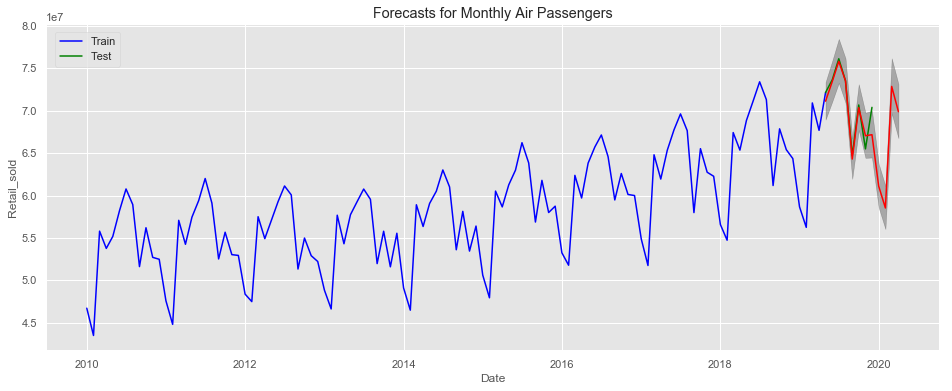

In [587]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(tsdf.iloc[:113].index, tsdf.iloc[:113]['PASSENGERS'], color = "blue")

ax.plot(df_test.index, df_test['PASSENGERS'], color = "green")

pred=result.get_forecast(steps=12)
pred_mean=np.exp(pred.predicted_mean)
pred_ci=np.exp(pred.conf_int())

ax.plot(pred_mean.index, pred_mean, color= "red")
ax.set_title("Forecasts for Monthly Air Passengers")


ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.3)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend(labels=['Train','Test'],loc=(0.01,0.87))
plt.show()

In [589]:
def mean_absolute_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## RANDOM EXPERIMENT

In [164]:
model2 = SARIMAX(np.log(df_train['SEATS']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['SEATS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model2.summary()

Optimization terminated successfully.
         Current function value: -2.486487
         Iterations: 4
         Function evaluations: 216


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              SEATS   No. Observations:                  104
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 258.595
Date:                            Fri, 06 Dec 2019   AIC                           -511.189
Time:                                    16:21:13   BIC                           -503.657
Sample:                                01-01-2010   HQIC                          -508.150
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5402      0.086     -6.284      0.000      -0.709      -0.372
ma.S.L12      -0.8522      0.269     -3.163      0.002      -1.380      -0.324
sigma2         0.0002   4.27e-05      3.948      0.000    8.49e-05       0.000
===================================================================================
Ljung-Box (Q):                       33.64   Jarque-Bera (JB):                23.18
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.31
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Available Seats (Red) vs. Actual (Blue)')

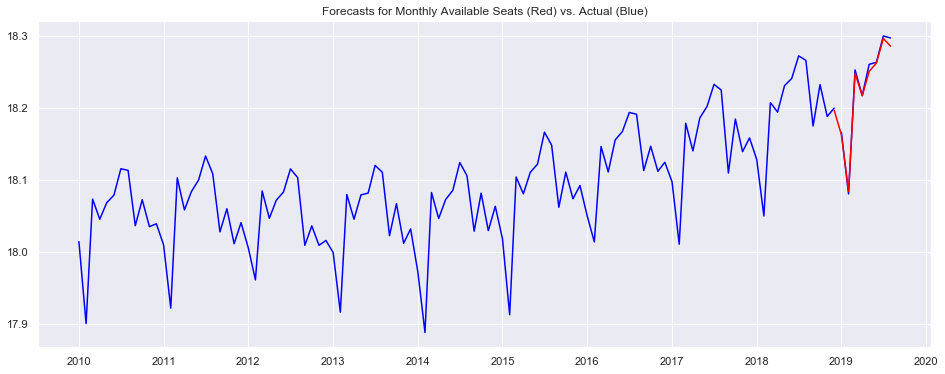

In [188]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['SEATS']), color = "blue")

ax.plot(df_test.index, np.log(df_test['SEATS']), color = "blue")

preds = model2.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Available Seats (Red) vs. Actual (Blue)")

In [175]:
model3 = SARIMAX(np.log(df_train['FREIGHT']), 
                order=(0,1,0), 
                seasonal_order=(0,1,0,12)).fit()
model3.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            FREIGHT   No. Observations:                  104
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 123.425
Date:                            Fri, 06 Dec 2019   AIC                           -244.850
Time:                                    16:24:34   BIC                           -242.340
Sample:                                01-01-2010   HQIC                          -243.837
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0039      0.001      5.754      0.000       0.003       0.005
===================================================================================
Ljung-Box (Q):                      357.78   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               0.77   Skew:                             0.25
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Freight (Red) vs. Actual (Blue)')

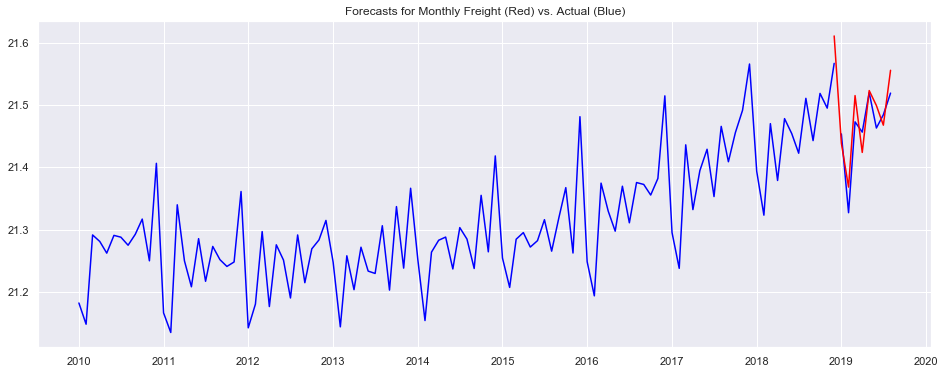

In [189]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['FREIGHT']), color = "blue")

ax.plot(df_test.index, np.log(df_test['FREIGHT']), color = "blue")

preds = model3.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Freight (Red) vs. Actual (Blue)")

In [177]:
model4 = SARIMAX(np.log(df_train['MAIL']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['MAIL'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model4.summary()

Optimization terminated successfully.
         Current function value: -1.124543
         Iterations: 3
         Function evaluations: 142


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               MAIL   No. Observations:                  104
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 116.952
Date:                            Fri, 06 Dec 2019   AIC                           -227.905
Time:                                    16:31:05   BIC                           -220.372
Sample:                                01-01-2010   HQIC                          -224.866
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3229      0.085     -3.812      0.000      -0.489      -0.157
ma.S.L12      -0.7492      0.134     -5.575      0.000      -1.013      -0.486
sigma2         0.0040      0.001      7.482      0.000       0.003       0.005
===================================================================================
Ljung-Box (Q):                      109.60   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.06   Skew:                            -0.13
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Mail (Red) vs. Actual (Blue)')

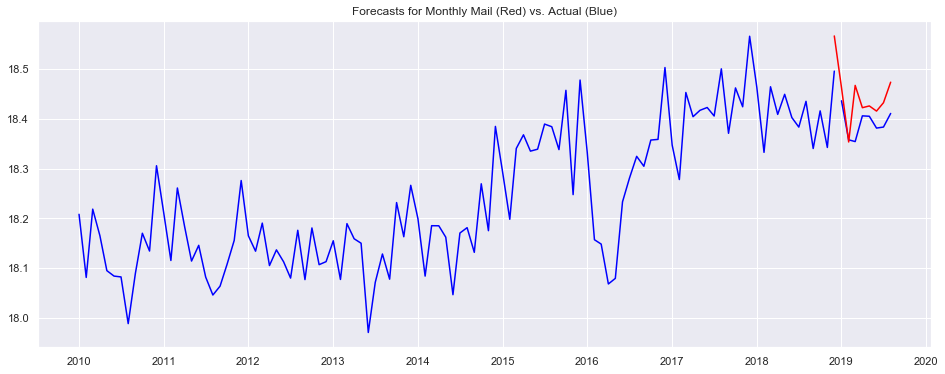

In [190]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['MAIL']), color = "blue")

ax.plot(df_test.index, np.log(df_test['MAIL']), color = "blue")

preds = model4.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Mail (Red) vs. Actual (Blue)")

In [191]:
df['EXCESS_SEATS'] = df.SEATS - df.PASSENGERS

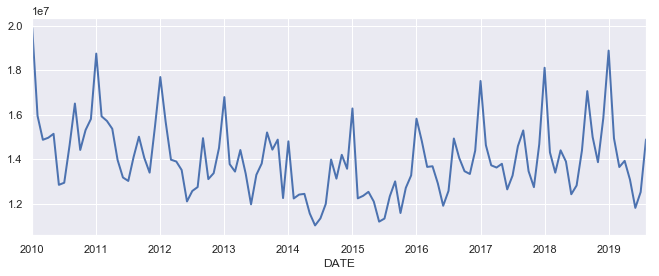

In [192]:
df['EXCESS_SEATS'].plot(linewidth = 2)

In [216]:
def mean_absolute_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat)

0.7366985512450689

In [231]:
yhat2 = np.exp(model2.forecast(8))
yhat3 = np.exp(model3.forecast(8))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [232]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat2)

0.7127267682208935

In [233]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat3)

0.5828390787492889

Text(0.5, 1.0, 'Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue), Model with AR Component')

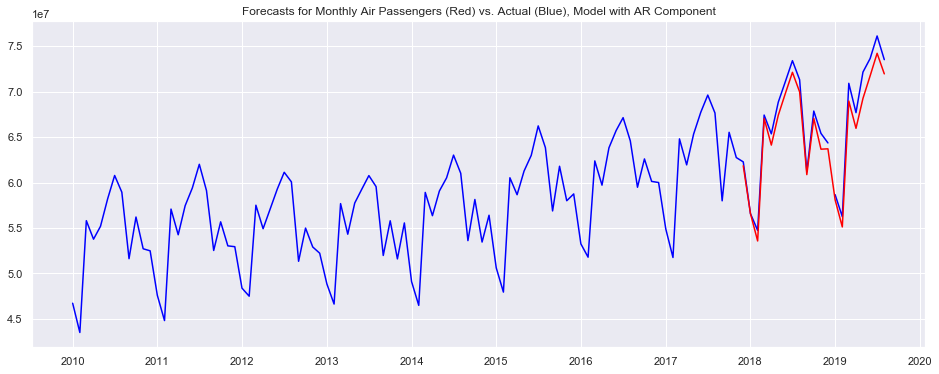

In [252]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, df_train['PASSENGERS'], color = "blue")

ax.plot(df_test.index, df_test['PASSENGERS'], color = "blue")

preds = model3.predict('2017-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, np.exp(preds), color= "red")
ax.set_title("Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue), Model with AR Component")

In [238]:
residuals3 = df_test.PASSENGERS - yhat3

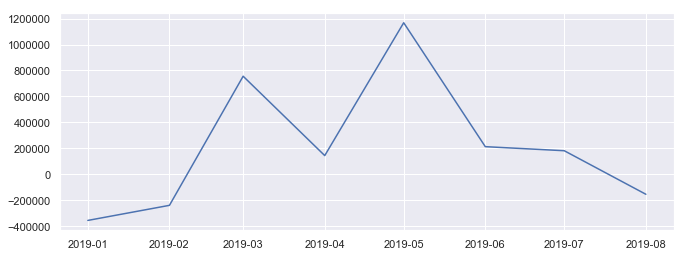

In [240]:
plt.plot(residuals3)

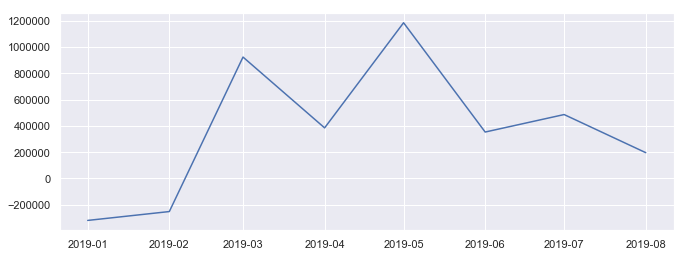

In [241]:
residuals = df_test.PASSENGERS - yhat
plt.plot(residuals)

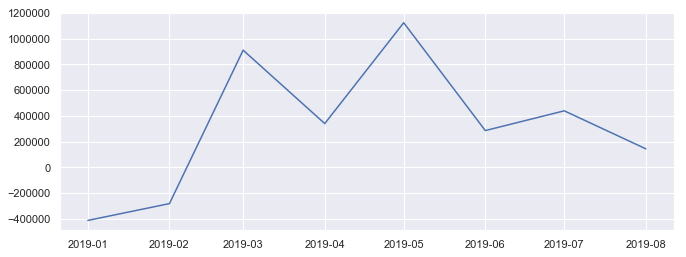

In [242]:
residuals2 = df_test.PASSENGERS - yhat2
plt.plot(residuals2)

Text(0.5, 1.0, 'Forecast for Air Passengers')

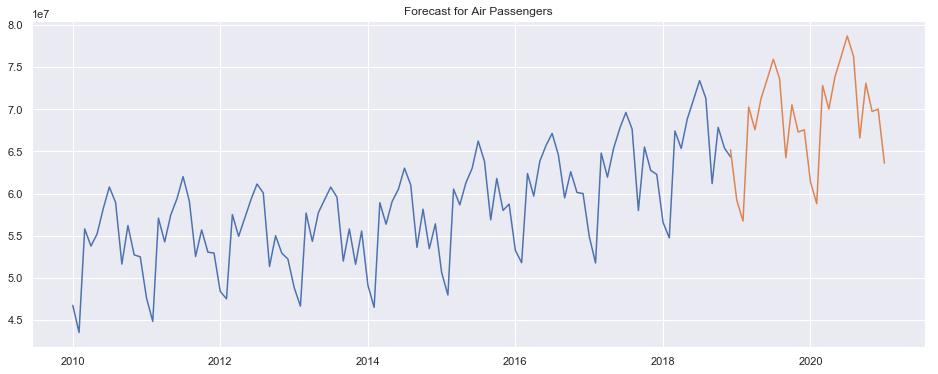

In [250]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, df_train.PASSENGERS)

preds = model.predict('2018-12-01', '2021', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, np.exp(preds))
ax.set_title("Forecast for Air Passengers")

In [278]:
df_train2 = df.iloc[72:108]
print(df_train2.head())
print(df_train2.shape)

                 PAYLOAD  PASSENGERS       SEATS       FREIGHT        MAIL  \
DATE                                                                         
2016-01-01  2.095267e+10  53250230.0  69067999.0  1.690818e+09  91545597.0   
2016-02-01  2.025451e+10  51786086.0  66593065.0  1.600357e+09  76848588.0   
2016-03-01  2.394425e+10  62383561.0  76033928.0  1.918059e+09  76178126.0   
2016-04-01  2.258120e+10  59715139.0  73394647.0  1.833499e+09  70318090.0   
2016-05-01  2.293399e+10  63827068.0  76736777.0  1.775617e+09  71110038.0   

            QUARTER  EXCESS_SEATS  
DATE                               
2016-01-01    32126    15817769.0  
2016-02-01    30742    14806979.0  
2016-03-01    31414    13650367.0  
2016-04-01    63092    13679508.0  
2016-05-01    60664    12909709.0  
(36, 7)


In [283]:
model_short = SARIMAX(np.log(df_train2['PASSENGERS']), 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12), enforce_invertibility=False).fit(method = 'powell')
model_short.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: maxlag should be < nobs